In [2]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.subplots as sp
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import tslearn.clustering as tsc
import matplotlib.dates as mdates

from sklearn.cluster import KMeans
import sklearn.preprocessing as pr
import sklearn.metrics as mt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer
from datetime import datetime

from tslearn.clustering import TimeSeriesKMeans

import matplotlib.patches as mpatches
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import euclidean
import importlib
import clustering_processing as cp, preprocessing as prep, cluster_grid

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [3]:
# Create min-max scaled combined dataframe with half-hourly timestamps from 01/01/2023-12/31/2023 as rows and site IDs as columns
# Site IDs with no air con or net load data were removed, Site IDs which had 
importlib.reload(prep)

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

#combined_df = prep.create_combined_df(cleaned_data_directory, date_range)
training_df, testing_df = prep.create_train_test_combined_df(cleaned_data_directory, date_range)
# Define the path for the CSV file
csv_path = os.path.join(base_directory, 'combined_aircon_profiles_training.csv')

# # Write to CSV only if the file doesn't already exist
if not os.path.exists(csv_path):
    training_df.to_csv(csv_path, index=False)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')

# # Write to CSV only if the file doesn't already exist
if not os.path.exists(os.path.join(base_directory, 'combined_aircon_profiles_testing.csv')):
    testing_df.to_csv(os.path.join(base_directory, 'combined_aircon_profiles_testing.csv'), index=False)
    print(f'File written: combined_aircon_profiles_testing.csv')
else:
    print('File already exists!')


File already exists!
File already exists!


In [4]:
# Pre-bin the "baseline" group with inputted thresholds for low consumption and create the dictionary for low consumption values.
# values were justified in other_investigations/parameter_sweep
importlib.reload(prep)
min_cons = 0.02 # pick a number to group low consumption profiles together
low_consumption_dict = prep.create_low_consumption_dict(training_df, min_cons=min_cons)


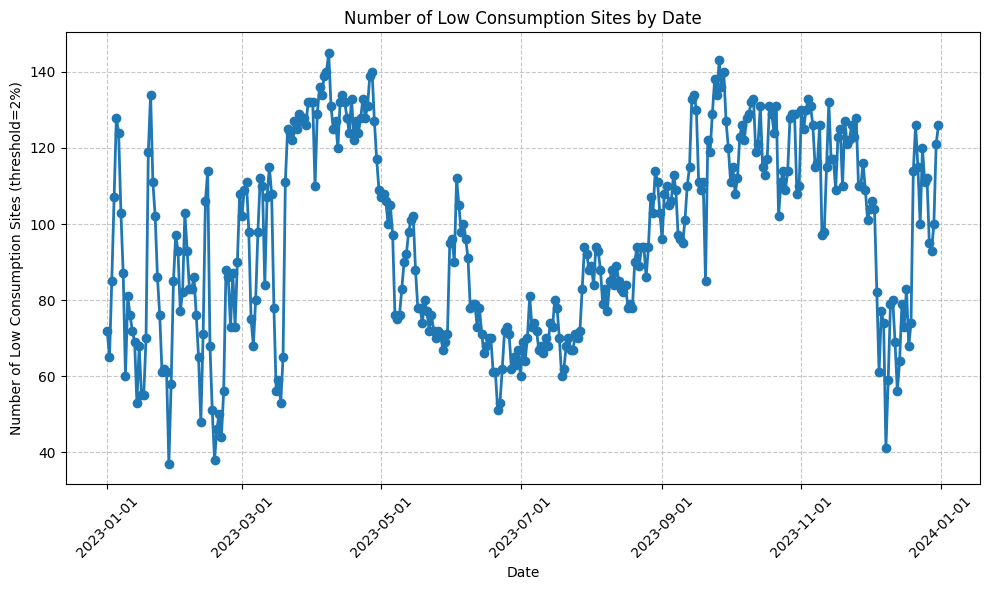

In [5]:
# Visualize Low Consumptions by Date 
# Extract dates and lengths into separate lists
dates = list(low_consumption_dict.keys())
num_sites = [len(sites) for sites in low_consumption_dict.values()]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dates, num_sites, marker='o', linestyle='-', linewidth=2)

# Customize the plot
plt.title('Number of Low Consumption Sites by Date')
plt.xlabel('Date')
plt.ylabel('Number of Low Consumption Sites (threshold=2%)')

# Format x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
importlib.reload(cluster_grid)
importlib.reload(cp)

def find_filtered_date_df(X, low_consumption_dict, date, feature_weights):
    
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 0.7,
            'summary_stats': 0.3
        }
    if date in low_consumption_dict:
        sites_to_remove = low_consumption_dict[date]
        # Find which sites actually exist in X
        sites_found = [site for site in sites_to_remove if site in X.columns]
        
        if sites_found:
            # print(f"Removing {len(sites_found)} low consumption sites for date {date}:")
            # print(f"Sites removed: {', '.join(sites_found)}")
            
            # Remove the sites
            X_filtered = X.drop(columns=sites_found)
        else:
            print(f"No sites to remove for date {date}")
            return X
    else:
        print(f"No low consumption sites listed for date {date}")


    #transpose X
    profiles = X_filtered
    print(X_filtered.shape)

    features_list = []
    # iterate through each row (profile) in the dataframe
    for profile_name in profiles.columns:
        profile = profiles[profile_name].values
        features = cp.calculate_time_series_features(profile)
        features_list.append(features)
    
    # Convert features to array and scale
    features_df = pd.DataFrame(features_list, index=profiles.columns)
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features_df)

    X_values = profiles.T.values
    # Combine scaled data using weights
    X_filtered_with_features = np.hstack([
        X_values * feature_weights['raw_profile'],
        features_scaled * feature_weights['summary_stats']
    ])

    X_filtered_with_features = pd.DataFrame(X_filtered_with_features.T, columns=profiles.columns)
    X_filtered = X_filtered.T
    #print("SAMPLE OF X FILTERED")
    #print(X_filtered.head(2))
    X_filtered_with_features = X_filtered_with_features.T
    #print("Sample of X filtered with features")
    #print(X_filtered_with_features.head(2))
    return X_filtered, X_filtered_with_features

def evaluate_clusters_kmeans(X, date, low_consumption_dict, min_clusters=4, max_clusters=8, feature_weights=None):
    """
    Input: training_df that's been modified to drop any site IDs with NA, 
    min cluster and max cluster are the constraints on maximum number of clusters
    feature weights: weight given to summary statistics vs. raw profile

    Output: silhouette scores, dbi scores, mia scores, combined indices for the selected date for range of number of clusters
    """
    X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_dict, date, feature_weights)
    
    sample_num = X_filtered_with_features.shape[0]
    silhouette_scores = [] 
    dbi_scores = [] 
    mia_scores = []
    combined_indices = []

    for n_clusters in range(min_clusters, max_clusters + 1): 
        try:
            kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=42) 
            labels = kmeans.fit_predict(X_filtered_with_features) # creates an array like (122,) with cluster number for each indexed site
            # Calculate scores
            sil_score = silhouette_score(X_filtered_with_features, labels)
            dbi_score = davies_bouldin_score(X_filtered_with_features, labels)
            mia_score = cluster_grid.mean_index_adequacy(X_filtered_with_features, labels)
            combined_index = (dbi_score * mia_score) / sil_score if sil_score != 0 else float('inf')

            silhouette_scores.append(sil_score) 
            dbi_scores.append(dbi_score)
            mia_scores.append(mia_score)
            combined_indices.append(combined_index)

        except Exception as e:
            print(f"Error with {n_clusters} clusters: {e}")
            silhouette_scores.append(float('nan'))
            dbi_scores.append(float('nan'))
            mia_scores.append(float('nan'))
            combined_indices.append(float('nan'))


    return silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num


def optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters = 4, max_clusters=8): 
    day_df_cleaned = day_df.drop(columns=['Timestamp']).dropna(axis=1, how='all')
    day_df_cleaned = day_df_cleaned.interpolate(method = 'linear') 
    if day_df_cleaned.shape[1] <= 1: 
        print(f"Skipping clustering for {day_df['Timestamp'].dt.date.iloc[0]} due to insufficient data.") 
        return None 

    # KMeans clustering 
    silhouette_scores, dbi_scores, mia_scores, combined_indices, sample_num = evaluate_clusters_kmeans(day_df_cleaned, date, low_consumption_dict, min_clusters, max_clusters, feature_weights=None) 
    optimal_clusters = np.argmin(combined_indices) + min_clusters
    optimal_score = combined_indices[optimal_clusters - min_clusters]
    optimal_silhouette = silhouette_scores[optimal_clusters - min_clusters] 
    optimal_dbi = dbi_scores[optimal_clusters - min_clusters] 
    optimal_mia = mia_scores[optimal_clusters - min_clusters] 
    return (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi, optimal_mia, sample_num) 


def main(df, low_consumption_dict): 
    df['Timestamp'] = pd.to_datetime(df['Timestamp']) 
    daily_results = [] 
    for date, day_df in df.groupby(df['Timestamp'].dt.date): 
        print(f"Processing date: {date}, data shape: {day_df.shape}") 
        optimal_result = optimize_clusters_for_day(day_df, date, low_consumption_dict, min_clusters=4, max_clusters=8) 
        if optimal_result is not None: 
            (optimal_clusters, optimal_score, optimal_silhouette, optimal_dbi, optimal_mia, sample_num) = optimal_result 
            daily_results.append({ 
                'Date': date, 
                'OptimalClusters': optimal_clusters, 
                'Combined_Index': optimal_score, 
                'Silhouette': optimal_silhouette, 
                'DBI': optimal_dbi, 
                'MIA': optimal_mia,
                'Total Number of Households': sample_num

            }) 

        else: 
            daily_results.append({ 
                'Date':date, 'OptimalClusters': None,'Combined_Index':None,'Silhouette': None, 'DBI': None, 'MIA': None, 'Total Number of Households':None}) 

    results_df = pd.DataFrame(daily_results) 
    results_df['Date'] = pd.to_datetime(results_df['Date']) 
    results_df = results_df.sort_values('Date') 
    print("Daily optimal clusters comparison processed.") 
    return results_df

# Example usage 

optimal_clusters_by_date = main(training_df, low_consumption_dict) 
print(optimal_clusters_by_date.head())

Processing date: 2023-01-01, data shape: (48, 189)
(48, 115)
Processing date: 2023-01-02, data shape: (48, 189)
(48, 122)
Processing date: 2023-01-03, data shape: (48, 189)
(48, 102)
Processing date: 2023-01-04, data shape: (48, 189)
(48, 80)
Processing date: 2023-01-05, data shape: (48, 189)
(48, 59)
Processing date: 2023-01-06, data shape: (48, 189)
(48, 63)
Processing date: 2023-01-07, data shape: (48, 189)
(48, 85)
Processing date: 2023-01-08, data shape: (48, 189)
(48, 101)
Processing date: 2023-01-09, data shape: (48, 189)
(48, 128)
Processing date: 2023-01-10, data shape: (48, 189)
(48, 107)
Processing date: 2023-01-11, data shape: (48, 189)
(48, 112)
Processing date: 2023-01-12, data shape: (48, 189)
(48, 116)
Processing date: 2023-01-13, data shape: (48, 189)
(48, 119)
Processing date: 2023-01-14, data shape: (48, 189)
(48, 135)
Processing date: 2023-01-15, data shape: (48, 189)
(48, 120)
Processing date: 2023-01-16, data shape: (48, 189)
(48, 133)
Processing date: 2023-01-17,

In [32]:
if not os.path.exists(os.path.join(base_directory, 'optimal_clusters_by_date.csv')):
    optimal_clusters_by_date.to_csv((os.path.join(base_directory, 'optimal_clusters_by_date.csv')), index=False)
    print(f'File written: optimal_clusters_by_date.csv')
else:
    print('File already exists!')

File written: optimal_clusters_by_date.csv


In [34]:
def process_multiple_days(df, start_date, end_date, optimal_clusters_by_date, low_consumption_sites_dict, 
                          
                        min_cluster_size=None, max_cluster_size=None, feature_weights=None):
    """
    Process multiple days of data using enhanced clustering with both raw profiles and features.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing pre-scaled load profiles with 'Timestamp' column
    start_date, end_date : str or datetime
        Start and end dates for processing
    optimal_clusters_by_date : int
       Dataframe containing optimal number of clusters for each date
    low_consumption_sites_dict : dict
        Dictionary of low consumption sites for each date
    min_cluster_size, max_cluster_size : int or None
        Minimum and maximum cluster sizes for constrained clustering
    feature_weights : dict, optional
        Dictionary of weights for different features (default: 0.7 for profiles, 0.3 for features)
    """
    if feature_weights is None:
        feature_weights = {
            'raw_profile': 0.7,
            'summary_stats': 0.3
        }
    
    
    dates = pd.date_range(start=pd.to_datetime(start_date).date(), 
                         end=pd.to_datetime(end_date).date())
    
    rlp_dict = {}
    cluster_sites_dict = {}


    for date in dates:
        # remove timestamp from date
        date_of_interest = date.date()
        print(date_of_interest)
        low_consumption_sites = [site for site in low_consumption_sites_dict.get(date_of_interest, [])]
        # slice X for that date
        X = df[df['Timestamp'].dt.date == date].drop(columns=['Timestamp']).dropna(axis=1, how='all')
        #X filtered is the combined df without the low consumption sites
        #X filtered with features is the combined df without low consumption sites and with the summary features as additional rows 
        X_filtered, X_filtered_with_features = find_filtered_date_df(X, low_consumption_sites_dict, date_of_interest, feature_weights)
        # Convert Date column to date object
        #print("printing x_filtered with features in process_multiple days function")
        #print(X_filtered_with_features.head())
        #print("printing x_filtered in process_multiple days function")
        #print(X_filtered.head())

        print(optimal_clusters_by_date['Date'].dtype)
        date_of_interest = pd.Timestamp(date_of_interest)

        num_clusters = optimal_clusters_by_date[optimal_clusters_by_date['Date'] == date_of_interest]['OptimalClusters'].values[0]
        
        # Perform clustering
        kmeans = TimeSeriesKMeans(
            n_clusters=num_clusters,
            random_state=42
        )
        labels = kmeans.fit_predict(X_filtered_with_features)
        centroids = kmeans.cluster_centers_ # centroids contains 
        #print("printing centroids stuff")
        # print(centroids.dtype)
        # print(centroids.shape)
        # print("printing labels stuff")
        # print(labels.shape)
        # print(labels.dtype) 
        # For each cluster, find the load profile closest to the centroid
        for cluster in range(num_clusters):
            # Get indices of sites in this cluster
            cluster_mask = labels == cluster
            # print("printing cluster_mask shape")
            # print(cluster_mask.shape)
            cluster_profiles = X_filtered[cluster_mask] # cluster profiles is a dataframe of all the profiles which fit in the cluster
            # print("printing cluster profiles")
            # print(cluster_profiles.shape)
            cluster_combined = X_filtered_with_features[cluster_mask]  # Combined dataframe (site ids as rows)
            # printing cluster combined type
            
            if len(cluster_profiles) > 0:  # Check if cluster is not empty
                # Calculate distances from each profile to the centroid
                print(centroids[cluster].squeeze().shape)
                #centroid_for_cluster = centroids[cluster].squeeze()
                distances = np.linalg.norm(cluster_combined - centroids[cluster].squeeze(), axis=1)
                
                # Find the index of the profile closest to centroid
                closest_profile_idx = np.argmin(distances)
                
                # print("printing head of cluster_profiles")
                # print(cluster_profiles.head())
                # print(closest_profile_idx)
                # Get the actual load profile closest to centroid
                rlp = cluster_profiles.iloc[closest_profile_idx]
                #rlp = cluster_profiles[closest_profile_idx]
                # print("printing rlp")
                # print(rlp.shape)
                # Store RLP in dictionary
                rlp_dict[f'{date.date()}_C{cluster+1}'] = np.array(rlp)
                
                # Store site_IDs for this cluster
                # filtered_site_ids should be the index of X_filtered_with
                filtered_site_ids = np.array(X_filtered_with_features.index)
                #filtered_site_ids = np.array(filtered_site_ids)

                # print("printing filtered site ids")
                # print(filtered_site_ids)
                # print(filtered_site_ids.shape)
                # print(filtered_site_ids.dtype)
                cluster_sites = filtered_site_ids[labels == cluster].tolist()
                cluster_sites_dict[f'{date.date()}_C{cluster+1}'] = cluster_sites

        # print("printing low consumption sites")
        # print(low_consumption_sites)
        """
        low consumption profile shape is being weird so i need to figure out what's going on with the low consumption rlp 
        also double check if the RLP being identified in the rest of the clusters is correct
        """
        # Handle the low consumption sites with complete data
        if low_consumption_sites:
            #print("yes there are low_consumption_sites")
            low_consumption_df = X[low_consumption_sites]
            # print("printing low consumption df")
            # print(low_consumption_df.head())
            if not low_consumption_df.empty:
                # Instead of using mean, find the most representative low consumption profile
                low_consumption_profiles = low_consumption_df.T
                # print("printing low consumption profiles shape")
                # print(low_consumption_profiles.shape)
                mean_profile = low_consumption_df.T.mean(axis=0).values
                # print(mean_profile.squeeze().shape)
                # Calculate distances from each profile to the mean
                distances = np.linalg.norm(low_consumption_profiles - mean_profile, axis=1)
                
                # Find the most representative profile (closest to mean)
                representative_idx = np.argmin(distances)

                low_consumption_rlp = low_consumption_profiles.iloc[representative_idx]
                # print(low_consumption_rlp.dtype)
                
                # Store the RLP for the low consumption sites as cluster 0
                rlp_dict[f'{date.date()}_C0'] = np.array(low_consumption_rlp)
                cluster_sites_dict[f'{date.date()}_C0'] = low_consumption_sites
        else:
            print("no low consumption sites???")
    # Convert results to DataFrames
    cluster_sites_df = pd.DataFrame.from_dict(cluster_sites_dict, orient='index')
    cluster_sites_df.index.name = 'Date_Cluster'
    cluster_sites_df = cluster_sites_df.reset_index().melt(
        id_vars=['Date_Cluster'],
        var_name='temp',
        value_name='site_ID'
    ).sort_values(by="Date_Cluster")
    cluster_sites_df = cluster_sites_df.dropna(subset=['site_ID']).drop('temp', axis=1)
    cluster_sites_df = cluster_sites_df.reset_index(drop=True)
    
    return rlp_dict, cluster_sites_df

rlp_dict, cluster_sites_df = process_multiple_days(training_df, '2023-01-01', '2023-12-31', optimal_clusters_by_date, low_consumption_dict)

2023-01-01
(48, 115)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-02
(48, 122)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-03
(48, 102)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-04
(48, 80)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-05
(48, 59)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-06
(48, 63)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-07
(48, 85)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-08
(48, 101)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_consumption_sites
2023-01-09
(48, 128)
datetime64[ns]
(51,)
(51,)
(51,)
(51,)
(51,)
(51,)
yes there are low_co

In [19]:
print(rlp_dict)

{'2023-01-01_C1': array([0.03023763, 0.01869749, 0.02694106, 0.02178449, 0.01892955,
       0.01697097, 0.03032302, 0.03384368, 0.03315186, 0.03230178,
       0.0313881 , 0.03142723, 0.03281073, 0.03278714, 0.03278731,
       0.03280841, 0.0248615 , 0.01991046, 0.02822573, 0.03581518,
       0.0357374 , 0.04251991, 0.04915506, 0.0454763 , 0.05028968,
       0.04449775, 0.03545325, 0.02739622, 0.02805298, 0.03509141,
       0.03129566, 0.03367456, 0.03720091, 0.049107  , 0.0477519 ,
       0.05231961, 0.05071306, 0.0334361 , 0.03298891, 0.02547003,
       0.07380043, 0.02200079, 0.04097976, 0.02860267, 0.02942278,
       0.02646901, 0.02336324, 0.02114953]), '2023-01-01_C2': array([0.00985756, 0.43399359, 0.27814703, 0.17834925, 0.11429805,
       0.18237111, 0.06448525, 0.1001767 , 0.1525774 , 0.0268545 ,
       0.15152187, 0.04397751, 0.12558068, 0.10434934, 0.06567382,
       0.15895766, 0.22221491, 0.22513125, 0.18953919, 0.17110513,
       0.3006978 , 0.38487783, 0.38452572, 0.4192

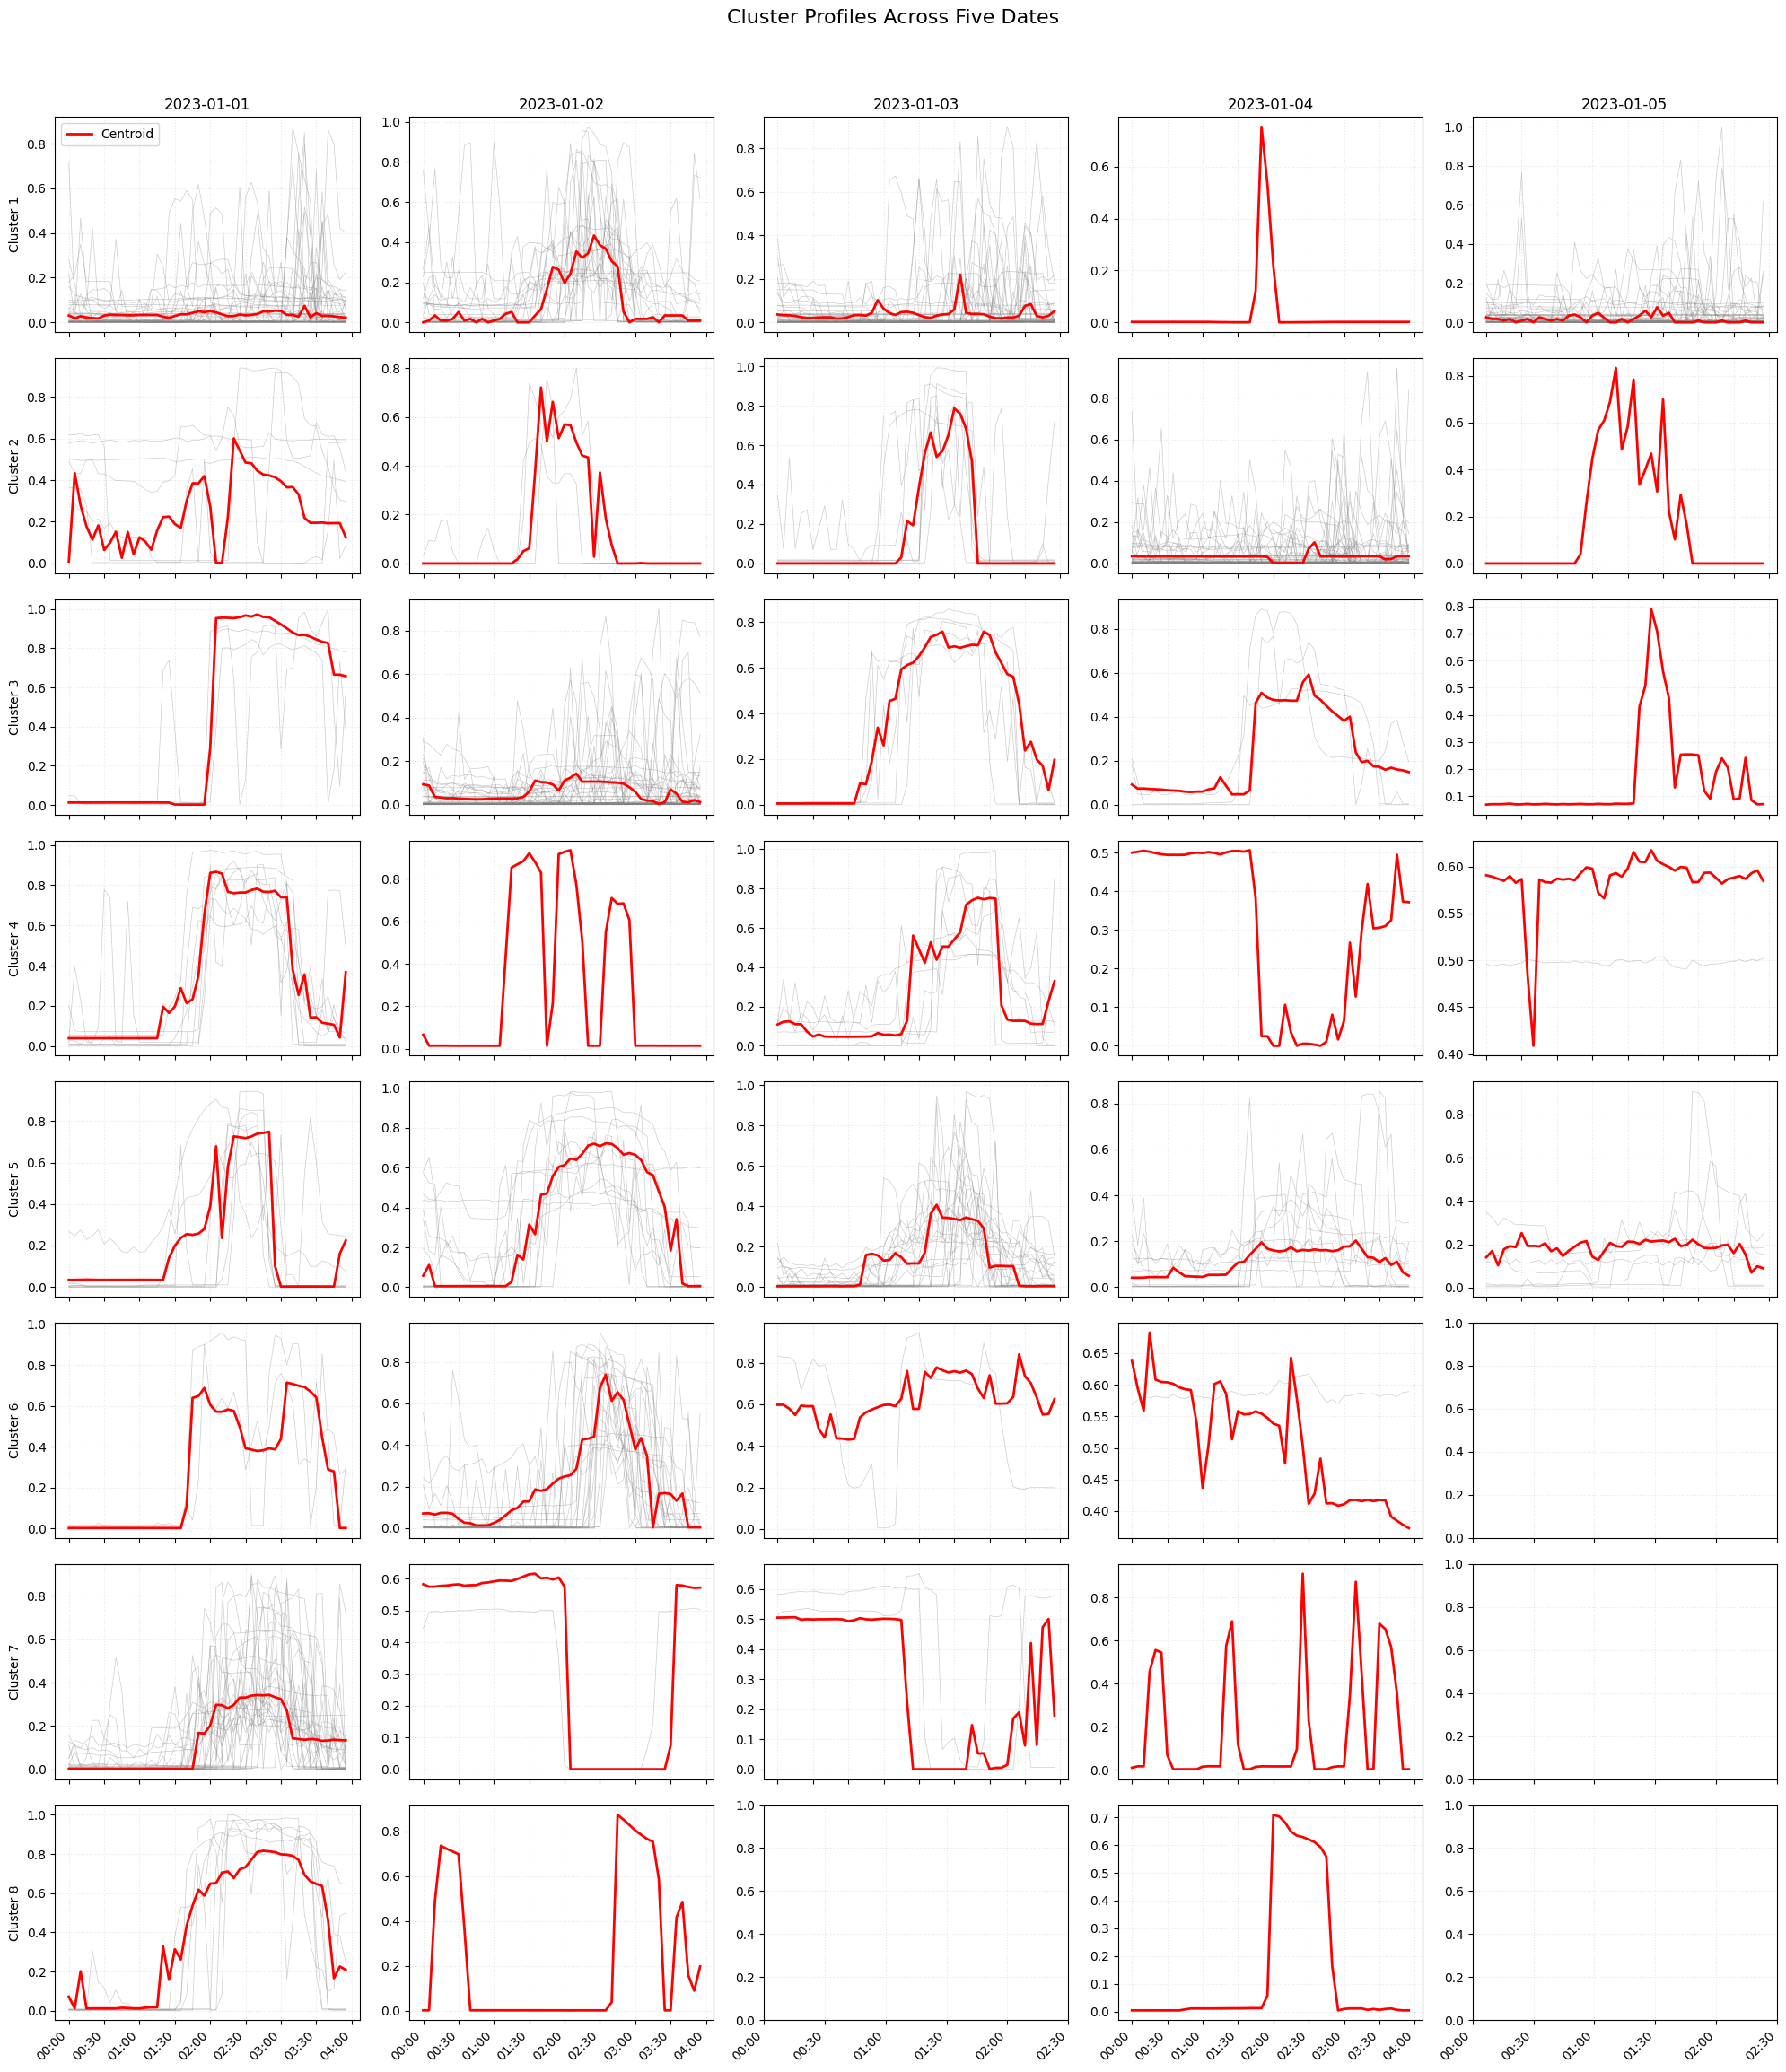

In [36]:

importlib.reload(cluster_grid)
selected_dates = ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05']
num_clusters = 8
# Example usage:
fig, axes = cluster_grid.visualize_cluster_grid(rlp_dict, cluster_sites_df, training_df, num_clusters, selected_dates)
plt.show()

In [35]:
#analyze cluster sizes
importlib.reload(cluster_grid)
# Example usage
result = cluster_grid.analyze_yearly_cluster_sizes(cluster_sites_df)

# Print summary statistics
print("Summary Statistics:")
for stat, value in result['summary_statistics'].items():
    print(f"{stat}: {value}")

Summary Statistics:
average_min_cluster_size: 1.7589041095890412
average_max_cluster_size: 98.01643835616439
total_clusters_with_1_sites: 464
total_clusters_with_2_sites: 320
days_analyzed: 365
total_days_in_year: 365


In [46]:
importlib.reload(cluster_grid)
rlp_aggregated = cluster_grid.aggregate_rlps(rlp_dict)

In [47]:
print(rlp_aggregated.head(2))

       2023-01-01_C1  2023-01-01_C2  2023-01-01_C3  2023-01-01_C4  \
00:00       0.030238       0.009858       0.012479       0.038514   
00:30       0.018697       0.433994       0.012342       0.038529   

       2023-01-01_C5  2023-01-01_C6  2023-01-01_C7  2023-01-01_C8  \
00:00       0.034035       0.001922       0.000928       0.072141   
00:30       0.034109       0.001909       0.000842       0.012546   

       2023-01-01_C0  2023-01-02_C1  ...  2023-12-30_C0  2023-12-31_C1  \
00:00       0.003377       0.000000  ...       0.004263       0.003980   
00:30       0.003363       0.008547  ...       0.004234       0.003984   

       2023-12-31_C2  2023-12-31_C3  2023-12-31_C4  2023-12-31_C5  \
00:00       0.033234       0.503727       0.000524       0.241143   
00:30       0.033256       0.506784       0.000521       0.239984   

       2023-12-31_C6  2023-12-31_C7  2023-12-31_C8  2023-12-31_C0  
00:00       0.086594       0.071820            0.0       0.004484  
00:30       0.073

PROGRESS: 

So far, what we have are the clusters for each day and we have extracted the RLPs for each cluster in each day. 
Input going forward will be the RLPs. 

NEXT STEP:
0. Find the optimal number of clusters for the RLPs 
1. Clustering of the RLPs 
2. Determine if sub-clustering is necessary

In [ ]:
# finding the best number of profile classes

importlib.reload(cp)
from cp import print_cluster_comparison_report, compare_cluster_sizes, evaluate_clustering_kmeans, mean_index_adequacy, aggregate_rlps, visualize_profile_classes, evaluate_clustering_dtw, evaluate_clustering_kmedoids, evaluate_clustering_kmeans_constrained, evaluate_clustering_kmeans_load_factor, calculate_load_factor

cluster_type = "kmeans"
min_clusters = 5
max_clusters = 15
cluster_results, best_clusters, Profile_Classes = compare_cluster_sizes(rlp_dict, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
print_cluster_comparison_report(cluster_results, best_clusters)



Evaluating 5 clusters...
Evaluating 6 clusters...
Evaluating 7 clusters...
Evaluating 8 clusters...
Evaluating 9 clusters...
Evaluating 10 clusters...
Evaluating 11 clusters...
Evaluating 12 clusters...
Evaluating 13 clusters...
Evaluating 14 clusters...
Evaluating 15 clusters...

=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
    Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
5             0.2763                1.5650               1.2948          7.3342              1.0                  4.0      11.0                  2.0
6             0.2565                1.5541               1.2587          7.6279              4.0                  2.0      10.0                  4.0
7             0.2639                1.5386               1.2464          7.2659              2.0                  1.0       9.0                  1.0
8             0.259

In [44]:
#cluster_results.to_csv(os.path.join(base_directory, 'optimal_profile_class_number_results.csv'), index=True)

In [50]:
print(best_clusters['Combined Index'])

7


(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Household Air Conditioner Electricity Consumption (Scaled)'>)

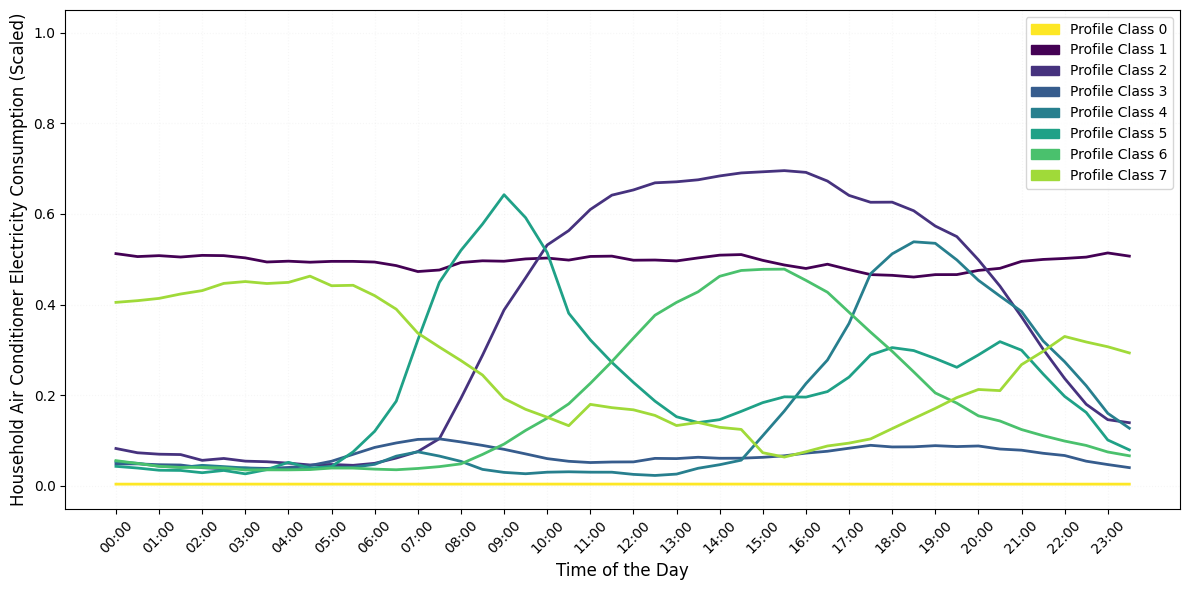

In [ ]:
importlib.reload(cp)
cp.visualize_profile_classes(rlp_aggregated, Profile_Classes, best_clusters['Combined Index'])


Profile Class Sizes:
-------------------
Profile Class 0.0: 365 members
Profile Class 1.0: 258 members
Profile Class 2.0: 179 members
Profile Class 3.0: 837 members
Profile Class 4.0: 247 members
Profile Class 5.0: 158 members
Profile Class 6.0: 371 members
Profile Class 7.0: 252 members


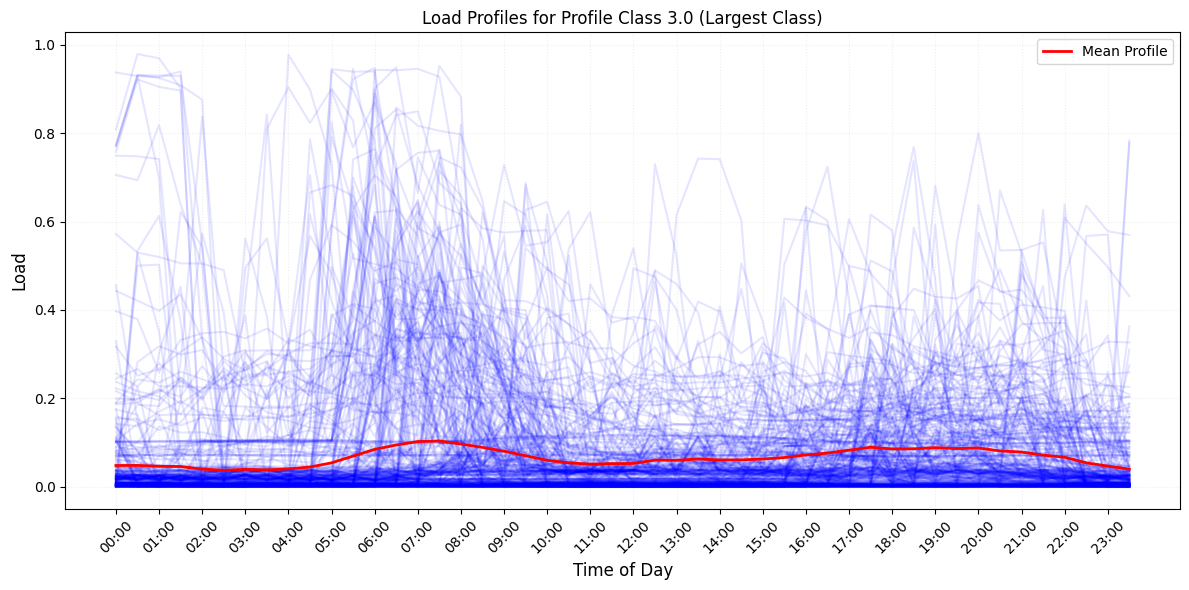

In [54]:
# Usage example:
importlib.reload(cp)
class_sizes, fig = cp.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [61]:
# Merging profile classes and cluster sites dataframes to get final assignments for each site on each day 
Profile_Classes.index.name = 'Date_Cluster' # set index name to match clusters 
date_range = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')

# Merge the two dataframes
merged_df = pd.merge(cluster_sites_df, Profile_Classes.reset_index(), on='Date_Cluster')


# Function to extract date from Date_Cluster
def extract_date(date_cluster):
    return pd.to_datetime(date_cluster.split('_')[0]).date()

merged_df['Date'] = merged_df['Date_Cluster'].apply(extract_date)

merged_df = merged_df.drop(columns = 'Date_Cluster')

# Create the final dataframe
prelim_PC_assignments = pd.pivot_table(merged_df, values='Profile_Class', index='Date', columns='site_ID', aggfunc='first')
# Reindex with the full date range
prelim_PC_assignments = prelim_PC_assignments.reindex(date_range)

for i in prelim_PC_assignments.columns:      
    prelim_PC_assignments[[i]] = prelim_PC_assignments[[i]].astype('Int64')

print(prelim_PC_assignments)


site_ID     S0024  S0083  S0089  S0106  S0107  S0110  S0111  S0159  S0173  \
2023-01-01      0      3      0      3      6      6      0      3      3   
2023-01-02      0      0      0      3      6      0      0      0      0   
2023-01-03      0      0      0      3      0      6      3      0      0   
2023-01-04      0      3      0      3      0      0      3      3      3   
2023-01-05      0      3      0      3      0      0      3      3      3   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2023-12-27      0      3      0      3      0      0      0      3      0   
2023-12-28      4      0      0      3      0      0      3      3      0   
2023-12-29      3      0      0      3      0      0      3      0      0   
2023-12-30      0      0      0      3      0      0      0      0      0   
2023-12-31      0      0      0      3      0      0      3      0      3   

site_ID     S0188  ...  W0318  W0319  W0322  W0325  W0332  W0341  W0345  \


In [62]:
#if it doesn't exist already, export final_df


csv_path = 'prelim_profile_class_assignments.csv'
if not os.path.exists(csv_path):
    prelim_PC_assignments.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')


File written: prelim_profile_class_assignments.csv


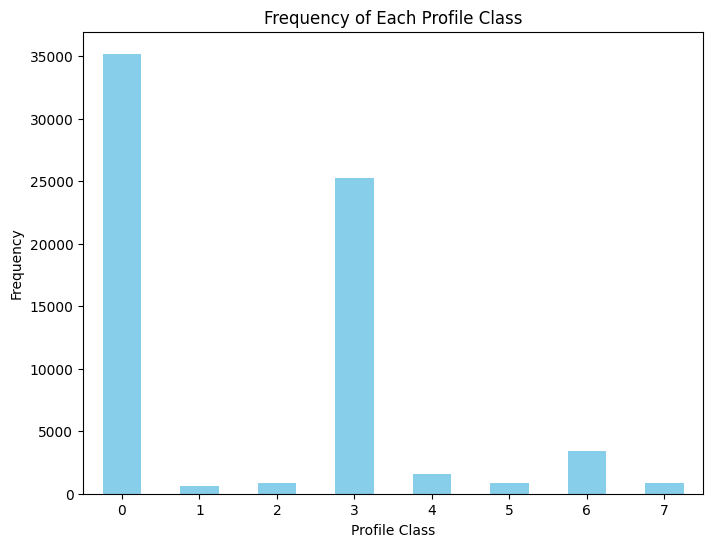

In [58]:
# Create figure of how many observations belong in each profile class 
frequency_counts = prelim_PC_assignments.values.flatten()

# Count the occurrences of each number (cluster label)
counts = pd.Series(frequency_counts).value_counts()

# Plot the frequency of each number
plt.figure(figsize=(8, 6))
counts.sort_index().plot(kind='bar', color='skyblue')

# Add labels and title
plt.xlabel('Profile Class')
plt.ylabel('Frequency')
plt.title('Frequency of Each Preliminary Profile Class')
plt.xticks(rotation=0)
plt.show()

In [59]:


importlib.reload(cp)

survey_df = pd.read_csv(os.path.join(base_directory, 'survey/survey_with_station.csv'))  # Change this to your output directory
survey_df.rename(columns={'edp_site_id': 'site_ID'}, inplace=True)

weather_folder_path = os.path.join(base_directory, 'weather/bom_data_max_min')  # Change this to your output directory
# Run the merger
result_df, incomplete_stations = cp.merge_site_weather_data(prelim_PC_assignments, survey_df, weather_folder_path)

print(incomplete_stations)

# if it doesn't exist already, export to csv

csv_path = 'df_for_regression_unconverted.csv'
if not os.path.exists(csv_path):
    result_df.to_csv(csv_path)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')



{}
File written: df_for_regression_unconverted.csv


Final Outputs from this script:
- df_for_regression_unconverted.csv
- prelim_profile_class_assignments.csv
Next Step is to go to the Sub-Clustering Script 